### Imports

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 26 11:38:22 2022

@author: lau
"""

#%% IMPORTS

import mne
from os.path import join
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1995)

### Sensor estimates/space

In [2]:
#%% PREPROCESSING FUNCTIONS
def preprocess_sensor_space_data(subject, date, raw_path,
                                 h_freq=40, # high pass filter
                                 tmin=-0.200, tmax=1.000, baseline=(None, 0),
                                 reject=None, decim=4, bad_channels=None): # decima = downsampling the data. 4 = 1000Hz -> 250Hz. The higher, the more downsampling.
    
    recording_names = ['001.self_block1',  '002.other_block1',
                       '003.self_block2',  '004.other_block2',
                       '005.self_block3',  '006.other_block3']
    
    epochs_list = []

    ######## PATHS ########
    for recording_index, recording_name in enumerate(recording_names):
        fif_fname = recording_name[4:]
        full_path = join(raw_path, subject, date, 'MEG', recording_name,
                         'files', fif_fname + '.fif') # this first section of the for loops just creates the path to the files
        
        print(full_path) # for debugging

        ######## RAW FILES AND FILTERING ########
        raw = mne.io.read_raw(full_path, preload=True) # loading the data into an mne object
        raw.filter(l_freq=None, h_freq=h_freq, n_jobs=3) 
                    # l_freq=None means we are not applying a low-pass filter
                    # h_freq: high pass filter
                    # n_jobs: number of jobs to run in parallel. -1 means use all processors. It's about processing speed.
        
        ######## FIND EVENTS ########
        # Finding events in the data. min_duration is the minimum duration of the event in seconds.
        events = mne.find_events(raw, min_duration=0.002) 

        if 'self' in recording_name:
            event_id = dict(self_positive=11, self_negative=12, # this is a dictionary that maps the event names to the event codes
                            button_press=202)
        elif 'other' in recording_name:
            event_id = dict(other_positive=21, other_negative=22, # this is a dictionary that maps the event names to the event codes
                            button_press=202)
        else:
            raise NameError('Event codes are not coded for file')
        
        # Epochs
        epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline,
                            preload=True, decim=decim, reject=reject,
                            proj=False) # have proj=True if we want to reject ^
        # epochs object contains the epochs of the raw data
        epochs.pick_types(meg=True) # select only MEG channels
        
        ######## EVOKED - AVERAGE OF EPOCHS ########
        epochs_list.append(epochs)
        
        if recording_index == 0:
            X = epochs.get_data()
            y = epochs.events[:, 2]
        else:
            X = np.concatenate((X, epochs.get_data()), axis=0)
            y = np.concatenate((y, epochs.events[:, 2]))
    
    return epochs_list

# Define a list of bad channels
bad_channels = ['MEG 0422']  # bad channels 

In [67]:
# plot timeseries: Here I can plot the timeseries for the first epoch of each of the six recordings by changing the value in []
#epochs_list[1].average().plot() # plot the average of the epochs for the last recording (other_block3)

### Source estimates

In [3]:
# gives the X data that we need for classification
def preprocess_source_space_data(subject, date, raw_path, subjects_dir,
                                 epochs_list,
                              method='MNE', lambda2=1, pick_ori='normal',
                              label=None):
    # Here we are just saying that if we don't have a epochs list, run the function above to get it
    if epochs_list is None:
        epochs_list = preprocess_sensor_space_data(subject, date, raw_path,
                                                   return_epochs=True)
    
    # Here we are concatenating event codes for all of the epochs
    ## ... GETTING y (label) ##
    y = np.zeros(0)
    for epochs in epochs_list: # get y
        y = np.concatenate((y, epochs.events[:, 2]))
    
    if label is not None:
        label_path = join(subjects_dir, subject, 'label', label)
        label = mne.read_label(label_path) # the label is used to specify a label for the source estimate
    else:
        label = None
    recording_names = ['001.self_block1',  '002.other_block1',
                       '003.self_block2',  '004.other_block2',
                       '005.self_block3',  '006.other_block3']
    
    ###### GETTING X ########
    for epochs_index, epochs in enumerate(epochs_list): ## get X        

        fwd_fname = recording_names[epochs_index][4:] + '-oct-6-src-' + \
                    '5120-fwd.fif'
        # the forward solution describes the relation between activity of sources and the sensors
        fwd = mne.read_forward_solution(join(subjects_dir,
                                             subject, 'bem', fwd_fname))
        
        # The noise covariance matrix is an estimate of the covariance
        # in the data, improving the accuracy of  the source estimates.
        # It is computed using the epochs that contain non-task-related
        # activity, i.e. the baseline.
        noise_cov = mne.compute_covariance(epochs, tmax=0.000)
        
        # inv 
        inv = mne.minimum_norm.make_inverse_operator(epochs.info,
                                                     fwd, noise_cov)
  
        # stcs is a list of source estimates for each epoch
        stcs = mne.minimum_norm.apply_inverse_epochs(epochs, inv, lambda2,
                                                     method, label,
                                                     pick_ori=pick_ori)
        
        # Concatenates the source estimates for each epoch into one array X
        for stc_index, stc in enumerate(stcs):
            this_data = stc.data # this is the data for the source estimate
            if epochs_index == 0 and stc_index == 0: # if this is the first epoch of the first recording
                n_trials = len(stcs) # then we know how many trials there are
                n_vertices, n_samples = this_data.shape # and we know the shape of the data
                this_X = np.zeros(shape=(n_trials, n_vertices, n_samples))
            this_X[stc_index, :, :] = this_data
            
        if epochs_index == 0:
            X = this_X
        else:
            X = np.concatenate((X, this_X))
    return X, y

In [4]:
def get_X_and_y(epochs_list):
    for recording_index in range(len(epochs_list)):
        these_epochs = epochs_list[recording_index]
        if recording_index == 0:
            X = these_epochs.get_data()
            y = these_epochs.events[:, 2]
        else:
            X = np.concatenate((X, these_epochs.get_data()), axis=0)
            y = np.concatenate((y, these_epochs.events[:, 2]))

    return X, y
    # X contains the data for the source estimates
    # y contains the event codes for the epochs

In [5]:
#%% RUNNING FUNCTIONS
rawpath = "/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG"
subjects_dir = "/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/835482"

epochs_list = preprocess_sensor_space_data('0111', '20230926_000000',
        raw_path= rawpath,
        decim=3) # don't go above decim=10
times = epochs_list[0].times # get time points for later

X_sensor, y = get_X_and_y(epochs_list) # shape= 720, 306, 121: 720 trials, 306 sensors, 121 time points (121 time points because of decim=10)


/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/001.self_block1/files/self_block1.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/001.self_block1/files/self_block1.fif...


/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_15567/686246554.py:22: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/001.self_block1/files/self_block1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True) # loading the data into an mne object


    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 430000 ... 811999 =    430.000 ...   811.999 secs
Ready.
Reading 0 ... 381999  =      0.000 ...   381.999 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed:    1.0s
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/adv_neuro_sci_venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


160 events found
Event IDs: [ 11  12  23 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.198, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...


[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.9s finished


0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/002.other_block1/files/other_block1.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/002.other_block1/files/other_block1.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 151000 ... 528999 =    151.000 ...   528.99

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_15567/686246554.py:22: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/002.other_block1/files/other_block1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True) # loading the data into an mne object


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  93 tasks      | elapsed:    0.8s
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/adv_neuro_sci_venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


161 events found
Event IDs: [ 21  22  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.198, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)


[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.0s finished


Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/003.self_block2/files/self_block2.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/003.self_block2/files/self_block2.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_15567/686246554.py:22: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/003.self_block2/files/self_block2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True) # loading the data into an mne object


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  93 tasks      | elapsed:    1.0s
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/adv_neuro_sci_venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


160 events found
Event IDs: [ 11  12  23 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.198, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)


[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    3.0s finished


Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/004.other_block2/files/other_block2.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/004.other_block2/files/other_block2.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        a

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_15567/686246554.py:22: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/004.other_block2/files/other_block2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True) # loading the data into an mne object


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  93 tasks      | elapsed:    1.0s
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/adv_neuro_sci_venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


161 events found
Event IDs: [ 21  22  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.198, 0.0] s
Applying baseline correction (mode: mean)


[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    2.9s finished


Created an SSP operator (subspace dimension = 9)
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/005.self_block3/files/self_block3.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/005.self_block3/files/self_block3.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_15567/686246554.py:22: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/005.self_block3/files/self_block3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True) # loading the data into an mne object


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  93 tasks      | elapsed:    0.8s
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/adv_neuro_sci_venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


161 events found
Event IDs: [ 11  12  23 103 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.198, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)


[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    2.7s finished


Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/006.other_block3/files/other_block3.fif
Opening raw data file /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/006.other_block3/files/other_block3.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        a

/var/folders/ll/fp10h_1j0d1ddcld2t3r_dpr0000gn/T/ipykernel_15567/686246554.py:22: RuntimeWarning: This filename (/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/MEG/0111/20230926_000000/MEG/006.other_block3/files/other_block3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw(full_path, preload=True) # loading the data into an mne object


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  93 tasks      | elapsed:    0.9s
/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/adv_neuro_sci_venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


160 events found
Event IDs: [ 21  22  23 202]
Not setting metadata
120 matching events found
Setting baseline interval to [-0.198, 0.0] s
Applying baseline correction (mode: mean)


[Parallel(n_jobs=3)]: Done 306 out of 306 | elapsed:    2.8s finished


Created an SSP operator (subspace dimension = 9)
Using data from preloaded Raw for 120 events and 1201 original time points (prior to decimation) ...
0 bad epochs dropped
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [6]:
# reads the sensor space data and do source reconstruction of each the trials. 
#X_source, y = preprocess_source_space_data('0111', '20230926_000000',
#        raw_path=rawpath, 
#        subjects_dir=subjects_dir,
#        epochs_list=epochs_list)

 # Source estimates for the left hemisphere Broca's area 44
#X_lh_BA44, y = preprocess_source_space_data('0111', '20230926_000000',
#        raw_path=rawpath, 
#        subjects_dir=subjects_dir,
#        label='lh.BA44_exvivo.label', epochs_list=epochs_list) # label argument refers to freesurfer/0108/label/lh.BA44_exvivo.label which is the labels of the BA44 region in the brain. Sort of a inner map of the brain.
       

# Source estimates for the left hemisphere primary Visual area (V1)
#X_lh_V1, y = preprocess_source_space_data('0111', '20230926_000000', # same as above but for V1.
#        raw_path=rawpath, 
#        subjects_dir=subjects_dir,
#        label='lh.V1_exvivo.label', epochs_list=epochs_list)
        

# https://en.wikipedia.org/wiki/Fusiform_gyrus#:~:text=the%20following%20pathways%3A-,Processing%20of%20color%20information,-%5Bedit%5D
# Source estimates for Fusiform Gyrus
##X_lh_FG, y = preprocess_source_space_data('0111', '20230926_000000', # same as above but for V1.
#        raw_path=rawpath, 
#        subjects_dir=subjects_dir,
#        label='lh.fusiform.label', epochs_list=epochs_list)

# sourc eestimates for transverse temporal gyrus (auditory cortex)
## "often associated with the primary auditory cortex"
#X_lh_TTG, y = preprocess_source_space_data('0111', '20230926_000000', # same as above but for V1.
#        raw_path=rawpath, 
#        subjects_dir=subjects_dir,
#        label='lh.transversetemporal.label', epochs_list=epochs_list)

In [13]:
# seeing number of button presses in each trial
def get_button_presses(epochs_list):
    for recording_index in range(len(epochs_list)):
        these_epochs = epochs_list[recording_index]
        if recording_index == 0:
            y = these_epochs.events[:, 2]
        else:
            y = np.concatenate((y, these_epochs.events[:, 2]))

    return y

trial_1_triggers = get_button_presses(epochs_list[4])
print(trial_1_triggers)
#number of button presses in trial 1 (23)
trial_1_triggers[trial_1_triggers == 11].shape

[12 11 11 12 12 23 11 23 11 11 11 12 11 23 12 23 12 11 23 11 11 11 23 23
 23 12 12 23 23 11 12 23 23 23 12 23 23 11 23 12 11 12 12 23 11 12 11 12
 23 23 23 11 11 12 11 12 12 23 23 23 12 12 12 11 11 23 12 12 11 23 23 11
 23 11 11 12 23 23 11 11 11 11 11 23 12 12 23 12 11 11 12 11 11 12 11 23
 12 11 23 23 12 23 12 23 23 12 11 12 12 23 12 12 23 11 23 11 12 11 12 12]


(40,)

## Classification functions

### Simple classification functions (log reg)

In [85]:
#%% SIMPLE CLASSIFICATION

# Get indicies of the events we want to classify: self positive and self negative or button press
def get_indices(y, triggers):
    indices = list()
    for trigger_index, trigger in enumerate(y):
        if trigger in triggers:
            indices.append(trigger_index)
            
    return indices

# purpose of equalize_number_of_indices would likely be to
# ensure that you have an equal number of samples for 
# each class or event you want to classify
def equalize_number_of_indices(): # write this yourself
    pass

def simple_classication(X, y, triggers, penalty='none', C=1.0):

    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    
    n_samples = X.shape[2]
    indices = get_indices(y, triggers)
    # equalize_number_of_indices()
    X = X[indices, :, :]
    y = y[indices]
    logr = LogisticRegression(penalty=penalty, C=C, solver='newton-cg')
    sc = StandardScaler() # especially necessary for sensor space as
                          ## magnetometers
                          # and gradiometers are on different scales 
                          ## (T and T/m)
    cv = StratifiedKFold()
    
    mean_scores = np.zeros(n_samples)
    
    for sample_index in range(n_samples):
        this_X = X[:, :, sample_index]
        sc.fit(this_X)
        this_X_std = sc.transform(this_X)
        scores = cross_val_score(logr, this_X_std, y, cv=cv)
        mean_scores[sample_index] = np.mean(scores)
        print(sample_index)
        
    return mean_scores

def plot_classfication(times, mean_scores, title=None):

    plt.figure()
    plt.plot(times, mean_scores)
    plt.hlines(0.50, times[0], times[-1], linestyle='dashed', color='k')
    plt.ylabel('Proportion classified correctly')
    plt.xlabel('Time (s)')
    if title is None:
        pass
    else:
        plt.title(title)
    plt.show()


### SVM classication function

In [128]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC  # Use SVC for Support Vector Classification


def SVM_classification(X, y, triggers, penalty='none', C=1.0):

    n_samples = X.shape[2]
    indices = get_indices(y, triggers)  # Assuming you have a function get_indices
    X = X[indices, :, :]
    y = y[indices]
    
    sc = StandardScaler()
    cv = StratifiedKFold()
    
    mean_scores = np.zeros(n_samples)
    
    # Define the parameter grid for SVM
    param_grid = {
        'C': [1.0],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto']
    }
    
    # Create SVM classifier
    svm = SVC(probability=True)
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(svm, param_grid, cv=cv)
    
    for sample_index in range(n_samples):
        this_X = X[:, :, sample_index]
        sc.fit(this_X)
        this_X_std = sc.transform(this_X)
        
        # Fit SVM using GridSearchCV
        grid_search.fit(this_X_std, y)
        
        # Get the best mean score from cross-validation
        best_score = grid_search.best_score_
        
        # Get the best hyperparameters
        best_params = grid_search.best_params_
        
        mean_scores[sample_index] = best_score
        print(f"Sample Index: {sample_index}, Best Mean Score: {best_score}, Best Hyperparameters: {best_params}")
    
    return mean_scores


## Classifications

### Fusiform gyrus (colors)

**Self talk**
* <span style="color:red">Self talk negative:</span> 12
* <span style="color:green">Self talk positive:</span> 11
* <span style="color:blue">Button press:</span> 23

**Other talk**
* <span style="color:red">Other talk positive:</span> 21
* <span style="color:green">Other talk negative:</span> 22
* <span style="color:blue">Button press:</span> 23

**Source estimates**

In [79]:
# Source estimates for Fusiform Gyrus
X_lh_FG, y = preprocess_source_space_data('0111', '20230926_000000', # same as above but for V1.
        raw_path=rawpath,
        subjects_dir=subjects_dir,
        label='lh.fusiform.label', epochs_list=epochs_list)

Reading forward solution from /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/835482/0111/bem/self_block1-oct-6-src-5120-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Computing rank from data with rank=None
    Using tolerance 4.3e-09 (2.2e-16 eps * 306 dim * 6.3e+04  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eigenvalues to zero (without PCA)


**Equalize**

In [40]:
def equalize_number_of_indices(X, y): # write this yourself
    import imblearn
    
    rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy={11: 60, 12: 60, 21: 60, 22: 60, 202: 240},random_state=42)
    
    rus.fit_resample(X[:,:,0], y)
    
    X_balanced = X[rus.sample_indices_]
    y_balanced = y[rus.sample_indices_]
    # Putting all 22s into 21s
    y_balanced_new = np.array([21 if y_balanced[i] == 22 else y_balanced[i] for i in range(len(y_balanced))])
    # putting all 11s, 12s, 21s, 22s into 15
    y_balanced_15_202 = np.array([15 if y_balanced[i] in [11, 12, 21, 22] else y_balanced[i] for i in range(len(y_balanced))])

    return X_balanced, y_balanced, y_balanced_new, y_balanced_15_202

# using the above function to balance the number of trials for each event
X_balanced, y_balanced, y_balanced_new, y_balanced_15_202 = equalize_number_of_indices(X_lh_FG, y)

**Tests - SVM**

In [ ]:
################ SVM ##################
# red other talk vs blue response SVM
sensor_neg_self_response_blue_SVM = SVM_classification(X_lh_FG,
                                  y, triggers=[21, 23], gamma='auto') # removed C=1.0 and penalty='none' from the arguments
################ SVM ##################

**Tests - Logistic regression**

In [45]:
# Green vs. Red self
sensor_pos_neg_self = simple_classication(X_lh_FG,
                                  y, triggers=[11, 12],
                                  penalty='l2', C=1e-3)

# Green vs blue (response)
sensor_pos_self_response = simple_classication(X_lh_FG,
                                  y, triggers=[11, 23],
                                  penalty='l2', C=1e-3) # equalize counts?!

# green vs. red other-talk
sensor_pos_neg_other = simple_classication(X_lh_FG,
                                  y, triggers=[22, 21],
                                  penalty='l2', C=1e-3)

# red other talk vs blue response
sensor_neg_self_response_blue = simple_classication(X_lh_FG,
                                  y, triggers=[21, 23],
                                  penalty='l2', C=1e-3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
8

#### Plotting classifications

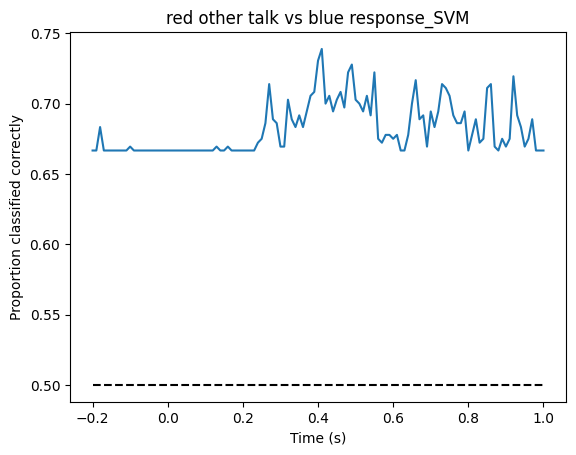

In [68]:
plot_classfication(times, sensor_pos_neg_self,
                   title='green-self vs. red-self')

plot_classfication(times, sensor_pos_self_response,
                   title='green-self vs. blue-response')

plot_classfication(times, sensor_pos_neg_other,
                   title="Green vs red other talk")

plot_classfication(times, sensor_neg_self_response_blue,
                   title="red other talk vs blue response")

############ SVM ###########
plot_classfication(times, sensor_neg_self_response_blue_SVM,
                   title="red other talk vs blue response_SVM")
############ SVM ###########

### Broca's area (BA44, BA45) (inner speech) (H1)

**Concatenating the two labels BA44 and BA45**

Docu for concatenation: https://mne.tools/stable/generated/mne.Label.html

In [47]:
# Function that concatenates two labels and creates a new label that is the concatenation of the two
def concatenate_labels(subject, subjects_dir, label1, label2, new_label_name):
    # Paths
    label1_path = join(subjects_dir, subject, 'label', label1)
    label2_path = join(subjects_dir, subject, 'label', label2)
    # reading labels
    label1 = mne.read_label(label1_path)
    label2 = mne.read_label(label2_path)
    # concatenating labels
    new_label = label1 + label2
    # saving new label
    new_label.save(join(subjects_dir, subject, 'label', new_label_name))

concatenate_labels('0111', subjects_dir, 'lh.BA45_exvivo.label','lh.BA44_exvivo.label', 'lh.BA44BA45_exvivo.label')

Saving label to : /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/835482/0111/label/lh.BA44BA45_exvivo.label


In [108]:
# Source estimates for the left hemisphere Broca's area 45
X_lh_BA44, y = preprocess_source_space_data('0111', '20230926_000000',
                raw_path=rawpath, 
                subjects_dir=subjects_dir, label='lh.BA44BA45_exvivo.label', epochs_list=epochs_list) # label argument refers to freesurfer/0108/label/lh.BA44_exvivo.label which is the labels of the BA44 region in the brain. Sort of a inner map of the brain.

Reading forward solution from /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/835482/0111/bem/self_block1-oct-6-src-5120-fwd.fif...
    Reading a source space...
    Computing patch statistics...


    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Computing rank from data with rank=None
    Using tolerance 4.3e-09 (2.2e-16 eps * 306 dim * 6.3e+04  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 306 -> 297
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 8040
[done]
Converting forward solution to surface orientation
    Average patch normals will be employed in the rota

**Equalize**

In [89]:
def equalize_number_of_indices(X, y): # write this yourself
    import imblearn
    
    rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy={11: 60, 12: 60, 21: 60, 22: 60, 202: 240},random_state=42)
    
    rus.fit_resample(X[:,:,0], y)
    
    X_balanced = X[rus.sample_indices_]
    y_balanced = y[rus.sample_indices_]
    # putting all 11s, 12s, 21s, 22s into 15
    y_balanced_15_202 = np.array([15 if y_balanced[i] in [11, 12, 21, 22] else y_balanced[i] for i in range(len(y_balanced))])

    return X_balanced, y_balanced, y_balanced_15_202

# using the above function to balance the number of trials for each event
X_balanced, y_balanced, y_balanced_15_202 = equalize_number_of_indices(X_lh_BA44, y)

**Support vector machines**

In [120]:
# classifiction with svm
self_talk_vs_button_press_Brocas_SVM = SVM_classification(X_balanced,
                                                          y_balanced_15_202, triggers=[15, 202],
                                                          penalty='l2')

Sample Index: 0, Best Mean Score: 0.6020833333333334, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 1, Best Mean Score: 0.60625, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 2, Best Mean Score: 0.5958333333333334, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 3, Best Mean Score: 0.5708333333333334, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 4, Best Mean Score: 0.5999999999999999, Best Hyperparameters: {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}
Sample Index: 5, Best Mean Score: 0.5958333333333334, Best Hyperparameters: {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}
Sample Index: 6, Best Mean Score: 0.5833333333333334, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 7, Best Mean Score: 0.5916666666666666, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 8, Best Mean Score: 0.6

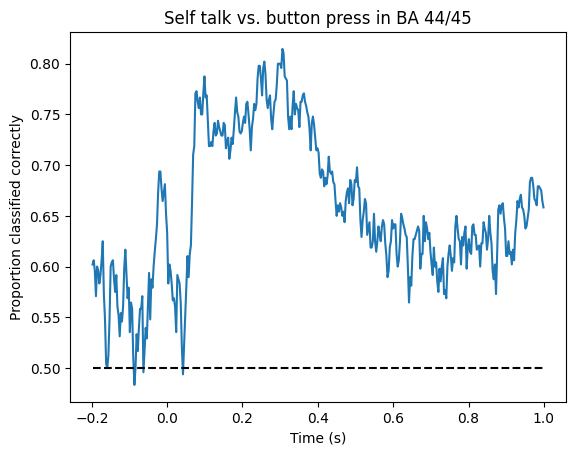

0.65656


In [121]:
plot_classfication(times, self_talk_vs_button_press_Brocas_SVM,
                   title='Self talk vs. button press in BA 44/45')

# mean accuracy score for the classification
print(round(np.mean(self_talk_vs_button_press_Brocas_SVM), 5))

**Logistic regression:**

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

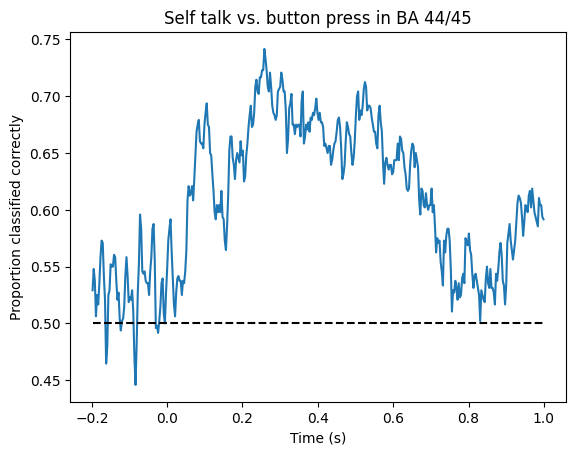

0.60913


In [93]:
self_talk_vs_button_press_Brocas = simple_classication(X_balanced,
                                                       y_balanced_15_202, triggers=[15, 202],
                                                       penalty='l2', C=1e-3)

plot_classfication(times, self_talk_vs_button_press_Brocas,
                   title='Self talk vs. button press in BA 44/45')

# mean accuracy score for the classification
print(round(np.mean(self_talk_vs_button_press_Brocas), 5))

0.609


### Primary Visual area (V1) (seeing stuff) - sanity check

**Self talk**
* <span style="color:red">Self talk negative:</span> 12
* <span style="color:green">Self talk positive:</span> 11
* <span style="color:blue">Button press:</span> 23

**Other talk**
* <span style="color:red">Other talk positive:</span> 21
* <span style="color:green">Other talk negative:</span> 22
* <span style="color:blue">Button press:</span> 23

In [122]:
# Source estimates for the left hemisphere Broca's area 45
X_lh_V1, y = preprocess_source_space_data('0111', '20230926_000000',
                raw_path=rawpath, 
                subjects_dir=subjects_dir, label='lh.V1_exvivo.label', epochs_list=epochs_list) # label argument refers to freesurfer/0108/label/lh.BA44_exvivo.label which is the labels of the BA44 region in the brain. Sort of a inner map of the brain.

Reading forward solution from /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/835482/0111/bem/self_block1-oct-6-src-5120-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Computing rank from data with rank=None
    Using tolerance 4.3e-09 (2.2e-16 eps * 306 dim * 6.3e+04  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eigenvalues to zero (without PCA)


In [126]:
def equalize_number_of_indices(X, y): # write this yourself
    import imblearn
    
    rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy={11: 60, 12: 60, 21: 60, 22: 60, 202: 240},random_state=42)
    
    rus.fit_resample(X[:,:,0], y)
    
    X_balanced = X[rus.sample_indices_]
    y_balanced = y[rus.sample_indices_]
    # putting all 11s, 12s, 21s, 22s into 15
    y_balanced_15_202 = np.array([15 if y_balanced[i] in [11, 12, 21, 22] else y_balanced[i] for i in range(len(y_balanced))])

    return X_balanced, y_balanced, y_balanced_15_202

X_balanced, y_balanced, y_balanced_15_202 = equalize_number_of_indices(X_lh_V1, y)

**SVM**

Sample Index: 0, Best Mean Score: 0.53125, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 1, Best Mean Score: 0.5291666666666667, Best Hyperparameters: {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}
Sample Index: 2, Best Mean Score: 0.5395833333333334, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 3, Best Mean Score: 0.5416666666666667, Best Hyperparameters: {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}
Sample Index: 4, Best Mean Score: 0.5541666666666667, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 5, Best Mean Score: 0.5375000000000001, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 6, Best Mean Score: 0.5541666666666667, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 7, Best Mean Score: 0.5416666666666666, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 8, Best Mean Score: 0.5

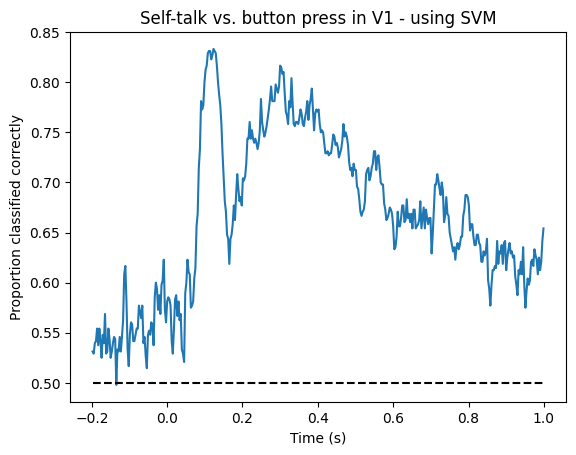

0.66629


In [130]:
sensor_self_talk_vs_button_V1_SVM = SVM_classification(X_balanced,
                                  y_balanced_15_202, triggers=[15, 202],
                                  penalty='l2', C=1e-3)

plot_classfication(times, sensor_self_talk_vs_button_V1_SVM,
                   title='Self-talk vs. button press in V1 - using SVM')

# mean accuracy score for the classification
print(round(np.mean(sensor_self_talk_vs_button_V1_SVM), 5))

**Logistic regression**

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

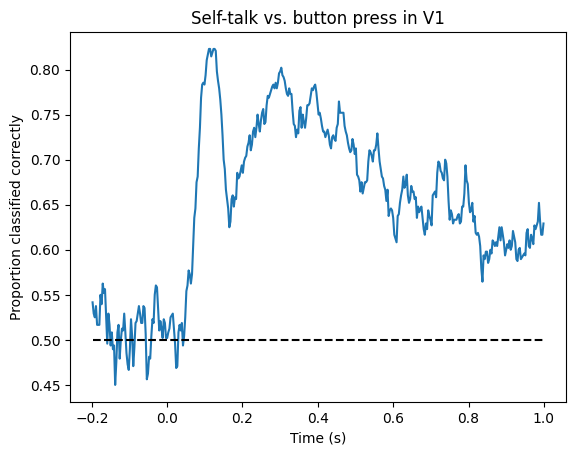

0.64925


In [98]:
sensor_self_talk_vs_button_V1 = simple_classication(X_balanced,
                                  y_balanced_15_202, triggers=[15, 202],
                                  penalty='l2', C=1e-3)

plot_classfication(times, sensor_self_talk_vs_button_V1,
                   title='Self-talk vs. button press in V1')

# mean accuracy score for the classification
print(round(np.mean(sensor_self_talk_vs_button_V1), 5))

In [96]:
print(round(np.mean(sensor_self_talk_vs_button_V1), 5))

0.60913


### Transverse temporal gyrus (auditory cortex)

**Self talk**
* <span style="color:red">Self talk negative:</span> 12
* <span style="color:green">Self talk positive:</span> 11
* <span style="color:blue">Button press:</span> 23

**Other talk**
* <span style="color:red">Other talk positive:</span> 21
* <span style="color:green">Other talk negative:</span> 22
* <span style="color:blue">Button press:</span> 23

In [131]:
# Source Estimates 
# source eestimates for transverse temporal gyrus (auditory cortex)
## "often associated with the primary auditory cortex"
X_lh_TTG, y = preprocess_source_space_data('0111', '20230926_000000', 
        raw_path=rawpath, 
        subjects_dir=subjects_dir,
        label='lh.transversetemporal.label', epochs_list=epochs_list) # transversetemporal -> auditory cortex

Reading forward solution from /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/835482/0111/bem/self_block1-oct-6-src-5120-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Computing rank from data with rank=None
    Using tolerance 4.3e-09 (2.2e-16 eps * 306 dim * 6.3e+04  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eigenvalues to zero (without PCA)


**Equalize**

In [132]:
def equalize_number_of_indices(X, y): # write this yourself
    import imblearn
    
    rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy={11: 60, 12: 60, 21: 60, 22: 60, 202: 240},random_state=42)
    
    rus.fit_resample(X[:,:,0], y)
    
    X_balanced = X[rus.sample_indices_]
    y_balanced = y[rus.sample_indices_]
    # Putting all 22s into 21s
    y_balanced_new = np.array([21 if y_balanced[i] == 22 else y_balanced[i] for i in range(len(y_balanced))])
    # putting all 11s, 12s, 21s, 22s into 15
    y_balanced_15_202 = np.array([15 if y_balanced[i] in [11, 12, 21, 22] else y_balanced[i] for i in range(len(y_balanced))])

    return X_balanced, y_balanced, y_balanced_new, y_balanced_15_202

# using the above function to balance the number of trials for each event
X_balanced, y_balanced, y_balanced_new, y_balanced_15_202 = equalize_number_of_indices(X_lh_TTG, y)

**SVM**

Sample Index: 0, Best Mean Score: 0.58125, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 1, Best Mean Score: 0.5729166666666666, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 2, Best Mean Score: 0.575, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 3, Best Mean Score: 0.5541666666666667, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 4, Best Mean Score: 0.5520833333333333, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 5, Best Mean Score: 0.5458333333333333, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 6, Best Mean Score: 0.54375, Best Hyperparameters: {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}
Sample Index: 7, Best Mean Score: 0.5625, Best Hyperparameters: {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}
Sample Index: 8, Best Mean Score: 0.575, Best Hyperparameters: {'C': 1.0,

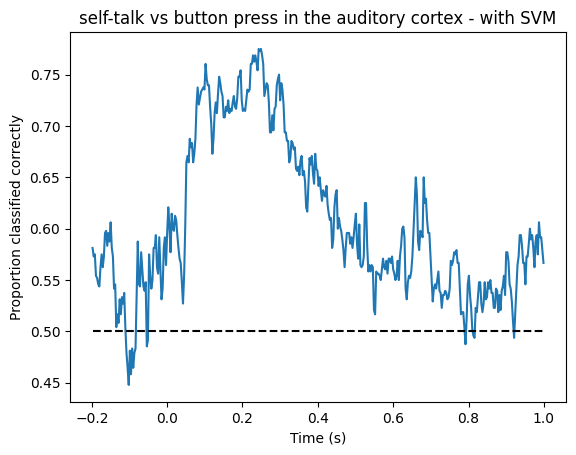

0.60616


In [133]:
sensor_self_vs_press_TTG_SVM = SVM_classification(X_balanced,
                                  y_balanced_15_202, triggers=[15, 202],
                                  penalty='l2', C=1e-3)

plot_classfication(times, sensor_self_vs_press_TTG_SVM,
                   title='self-talk vs button press in the auditory cortex - with SVM')

# mean accuracy score for the classification
print(round(np.mean(sensor_self_vs_press_TTG_SVM), 5))

**Logsistic regression Classification**

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

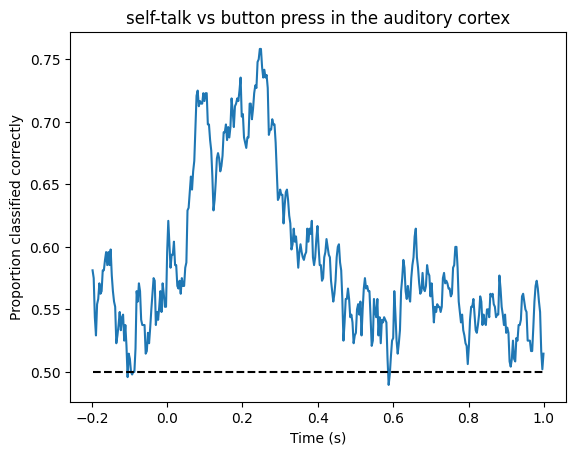

0.5882


In [102]:
sensor_self_vs_press_TTG = simple_classication(X_balanced,
                                  y_balanced_15_202, triggers=[15, 202],
                                  penalty='l2', C=1e-3)

plot_classfication(times, sensor_self_vs_press_TTG,
                   title='self-talk vs button press in the auditory cortex')

# mean accuracy score for the classification
print(round(np.mean(sensor_self_vs_press_TTG), 5))

#### Plots

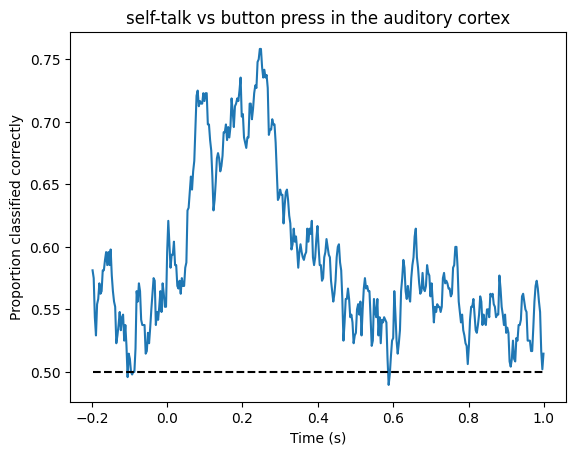

In [46]:
plot_classfication(times, sensor_self_vs_press_TTG,
                   title='self-talk vs button press in the auditory cortex')

### Motor cortex (precentral gyrus)

In [134]:
# Source estimates for the left hemisphere Broca's area 45
X_lh_PG, y = preprocess_source_space_data('0111', '20230926_000000',
                raw_path=rawpath, 
                subjects_dir=subjects_dir, label='lh.precentral.label', epochs_list=epochs_list) # label argument refers to freesurfer/0108/label/lh.BA44_exvivo.label which is the labels of the BA44 region in the brain. Sort of a inner map of the brain.

Reading forward solution from /Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/12b_MEG_analysis/data/835482/0111/bem/self_block1-oct-6-src-5120-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Computing rank from data with rank=None
    Using tolerance 4.3e-09 (2.2e-16 eps * 306 dim * 6.3e+04  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eigenvalues to zero (without PCA)


**Equalize**

In [135]:
def equalize_number_of_indices(X, y): # write this yourself
    import imblearn
    
    rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy={11: 60, 12: 60, 21: 60, 22: 60, 202: 240},random_state=42)
    
    rus.fit_resample(X[:,:,0], y)
    
    X_balanced = X[rus.sample_indices_]
    y_balanced = y[rus.sample_indices_]
    # Putting all 22s into 21s
    y_balanced_new = np.array([21 if y_balanced[i] == 22 else y_balanced[i] for i in range(len(y_balanced))])
    # putting all 11s, 12s, 21s, 22s into 15
    y_balanced_15_202 = np.array([15 if y_balanced[i] in [11, 12, 21, 22] else y_balanced[i] for i in range(len(y_balanced))])

    return X_balanced, y_balanced, y_balanced_new, y_balanced_15_202

# using the above function to balance the number of trials for each event
X_balanced, y_balanced, y_balanced_new, y_balanced_15_202 = equalize_number_of_indices(X_lh_PG, y)


**SVM**

Sample Index: 0, Best Mean Score: 0.6020833333333334, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 1, Best Mean Score: 0.60625, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 2, Best Mean Score: 0.5958333333333334, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 3, Best Mean Score: 0.5708333333333334, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 4, Best Mean Score: 0.5999999999999999, Best Hyperparameters: {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}
Sample Index: 5, Best Mean Score: 0.5958333333333334, Best Hyperparameters: {'C': 1.0, 'gamma': 'auto', 'kernel': 'rbf'}
Sample Index: 6, Best Mean Score: 0.5833333333333334, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 7, Best Mean Score: 0.5916666666666666, Best Hyperparameters: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
Sample Index: 8, Best Mean Score: 0.6

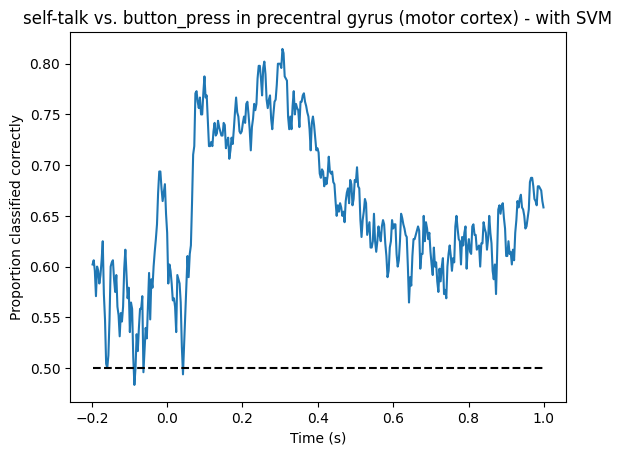

0.65656


In [136]:
# self positive vs button press
sensor_selfpositive_vs_buttonPress_SVM = SVM_classification(X_balanced,
                                  y_balanced_15_202, triggers=[15, 202],
                                  penalty='l2', C=1e-3)

plot_classfication(times, sensor_selfpositive_vs_buttonPress_SVM,
                   title='self-talk vs. button_press in precentral gyrus (motor cortex) - with SVM')

# mean accuracy score for the classification
print(round(np.mean(sensor_selfpositive_vs_buttonPress_SVM), 5))

**Classification and plotting**

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

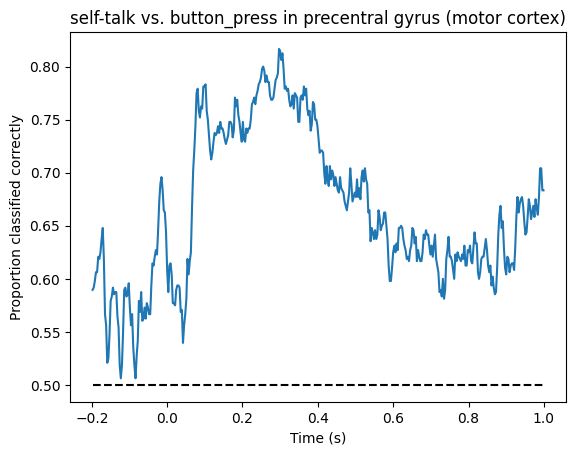

0.66503


In [106]:
# self positive vs button press
sensor_selfpositive_vs_buttonPress = simple_classication(X_balanced,
                                  y_balanced_15_202, triggers=[15, 202],
                                  penalty='l2', C=1e-3)

plot_classfication(times, sensor_selfpositive_vs_buttonPress,
                   title='self-talk vs. button_press in precentral gyrus (motor cortex)')

# mean accuracy score for the classification
print(round(np.mean(sensor_selfpositive_vs_buttonPress), 5))

### Getting accuracy scores

In [63]:
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img

from mne.datasets import sample
from mne import read_evokeds
from mne.minimum_norm import apply_inverse, read_inverse_operator

print(__doc__)

/Users/wibe/Desktop/CogSci/neuro/adv_neuro_science/adv_neuro_sci_venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(



Created on Wed Oct 26 11:38:22 2022

@author: lau

